In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [46]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl1path = workDir+'CV3_data/LVL1/'
lvl2path = workDir+'CV3_data/LVL2/'

infile = 'NonLinearityCorrection_OutputParameters_dic_CV3_MRS_RAD_14_IntegrationRamp1'
out_parameters_dic = funcs.load_obj(infile,path='obj/')
print out_parameters_dic.keys()

['1A', '3B', '3A', '3C']


<IPython.core.display.Javascript object>


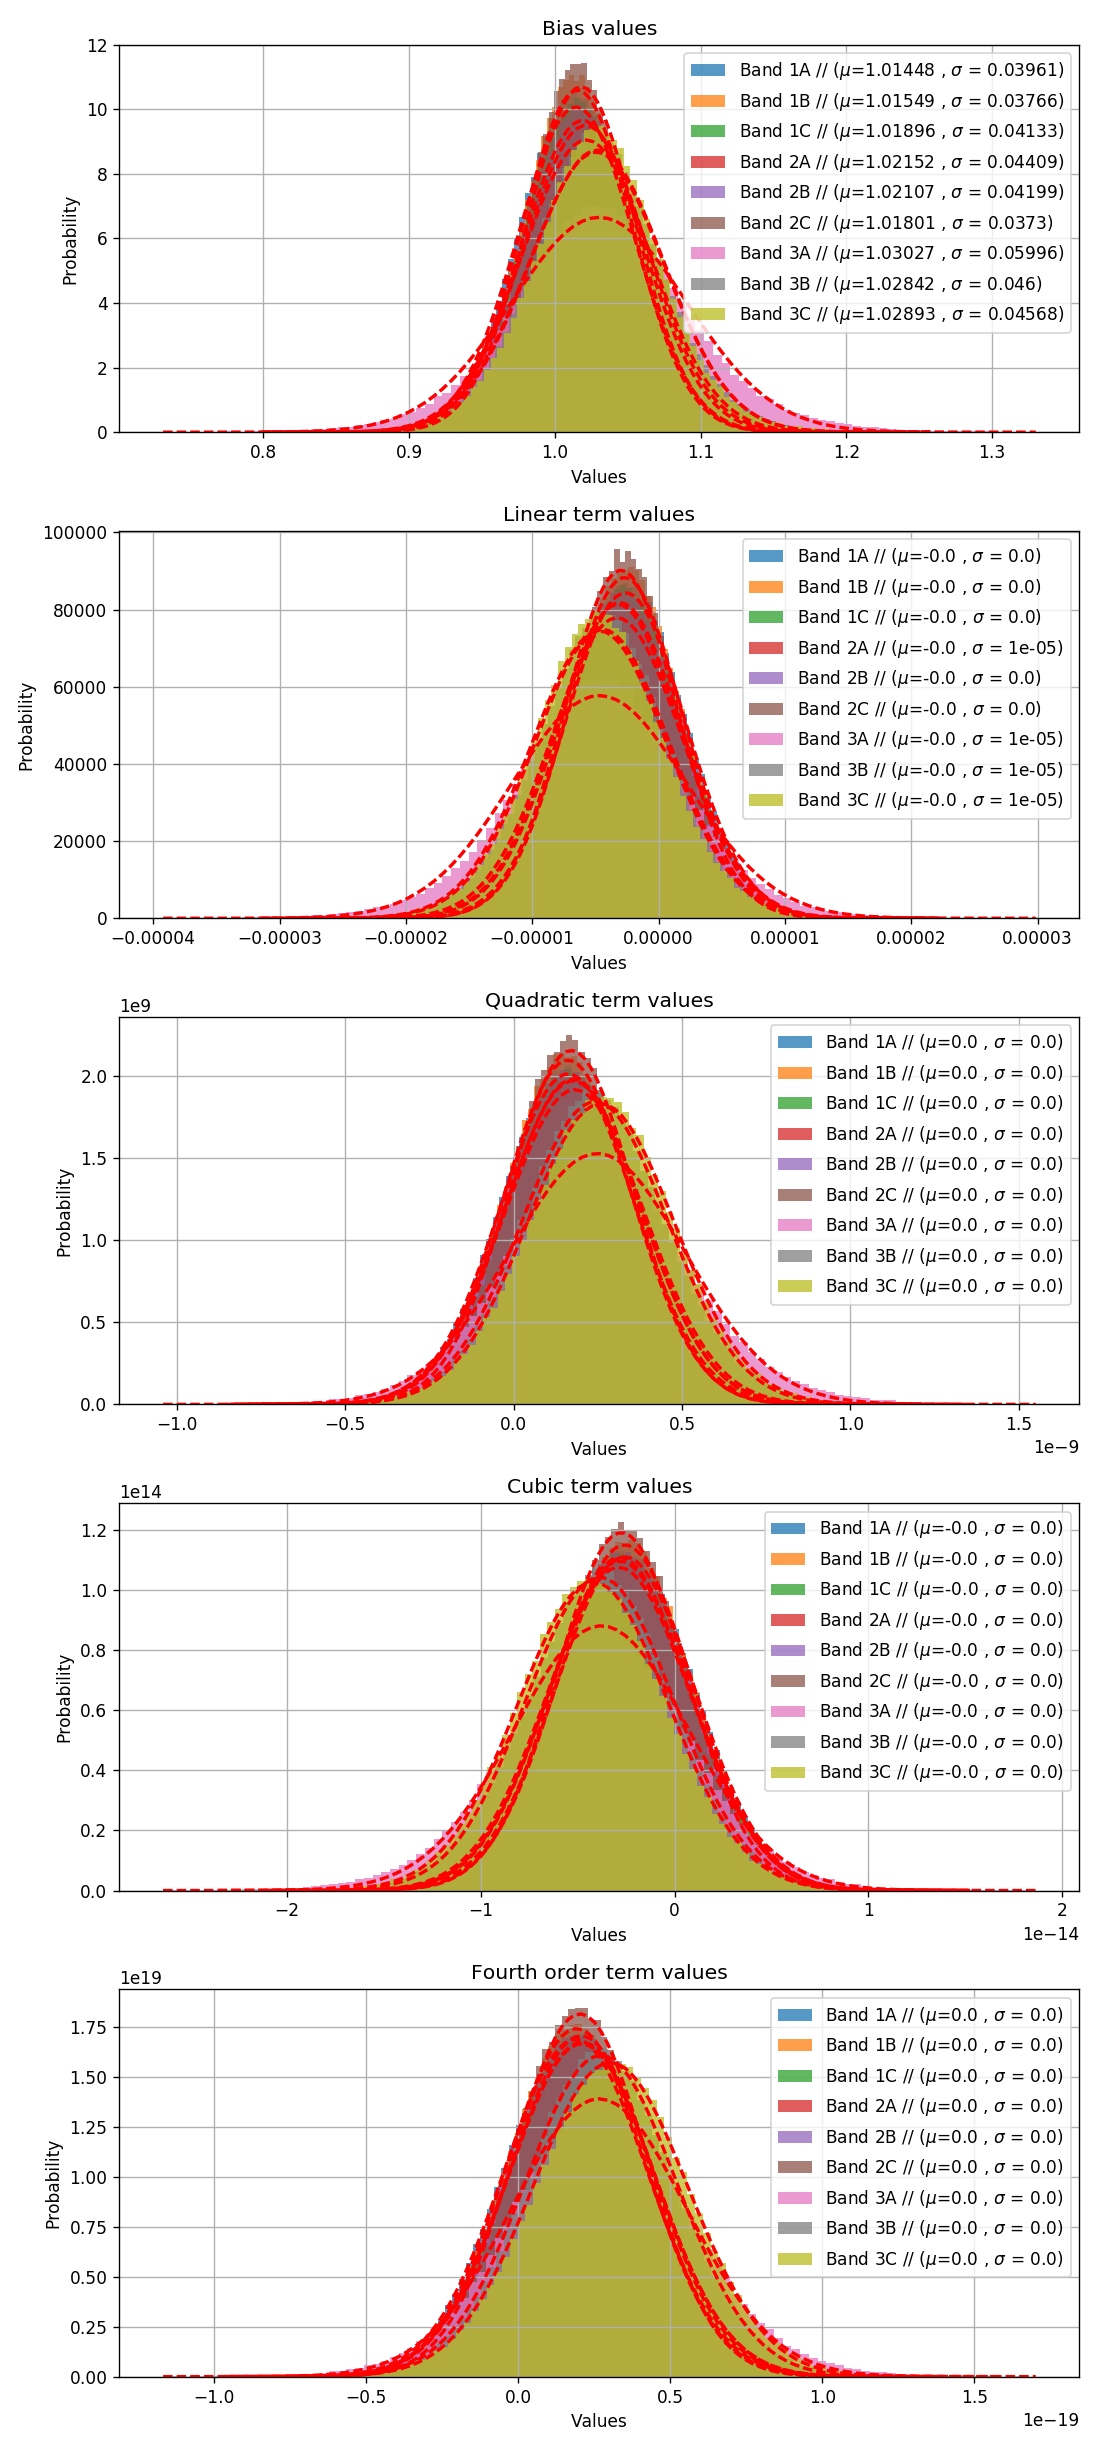

In [8]:
plt.close('all')
parameters =  {'0':'Bias','1':'Linear term','2':'Quadratic term','3':'Cubic term','4':'Fourth order term'}
parameter_range = {'0':[0.8,1.2],'1':[-30*1e-6,30*1e-6],'2':[-5*1e-10,10*1e-10],'3':[-15*1e-15,15*1e-15],'4':[-7*1e-20,10*1e-20]}
scale_factor = {'0':1,'1':10**6,'2':10**10,'3':10**15,'4':10**20}

fig,axs = plt.subplots(5,1,figsize=(9,20))
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C']: # ['1A','1B','1C','2A','2B','2C','3A','3B','3C']
    out_parameters = out_parameters_dic[band]
    
    d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
    sel = (d2cMaps['sliceMap'] > 100*int(band[0])) & (d2cMaps['sliceMap'] < 100*(int(band[0])+1) )
    
    for parameter in range(5):
        (mu, sigma) = norm.fit(out_parameters[parameter,:,:][sel][(out_parameters[parameter,:,:][sel] > parameter_range[str(parameter)][0]) & (out_parameters[parameter,:,:][sel] < parameter_range[str(parameter)][1])])

        n, bins, patches = axs[parameter].hist(out_parameters[parameter,:,:][sel][(out_parameters[parameter,:,:][sel] > mu-5*sigma) & (out_parameters[parameter,:,:][sel] < mu+5*sigma)], 100, normed=1, alpha=0.75,label=r'Band {} // ($\mu$={} , $\sigma$ = {})'.format(band,round(mu*scale_factor[str(parameter)],5), round(sigma*scale_factor[str(parameter)],5) ))
        y = mlab.normpdf(bins, mu, sigma)
        axs[parameter].plot(bins, y, 'r--', linewidth=2)
for plot in range(5):
    axs[plot].set_xlabel('Values')
    axs[plot].set_ylabel('Probability')
    axs[plot].set_title('{} values'.format(parameters[str(plot)]))
    axs[plot].legend()
    axs[plot].grid(True)
plt.tight_layout()

In [36]:
mean_values_dic,sigma_values_dic,wavl_dic = {},{},{}

<IPython.core.display.Javascript object>


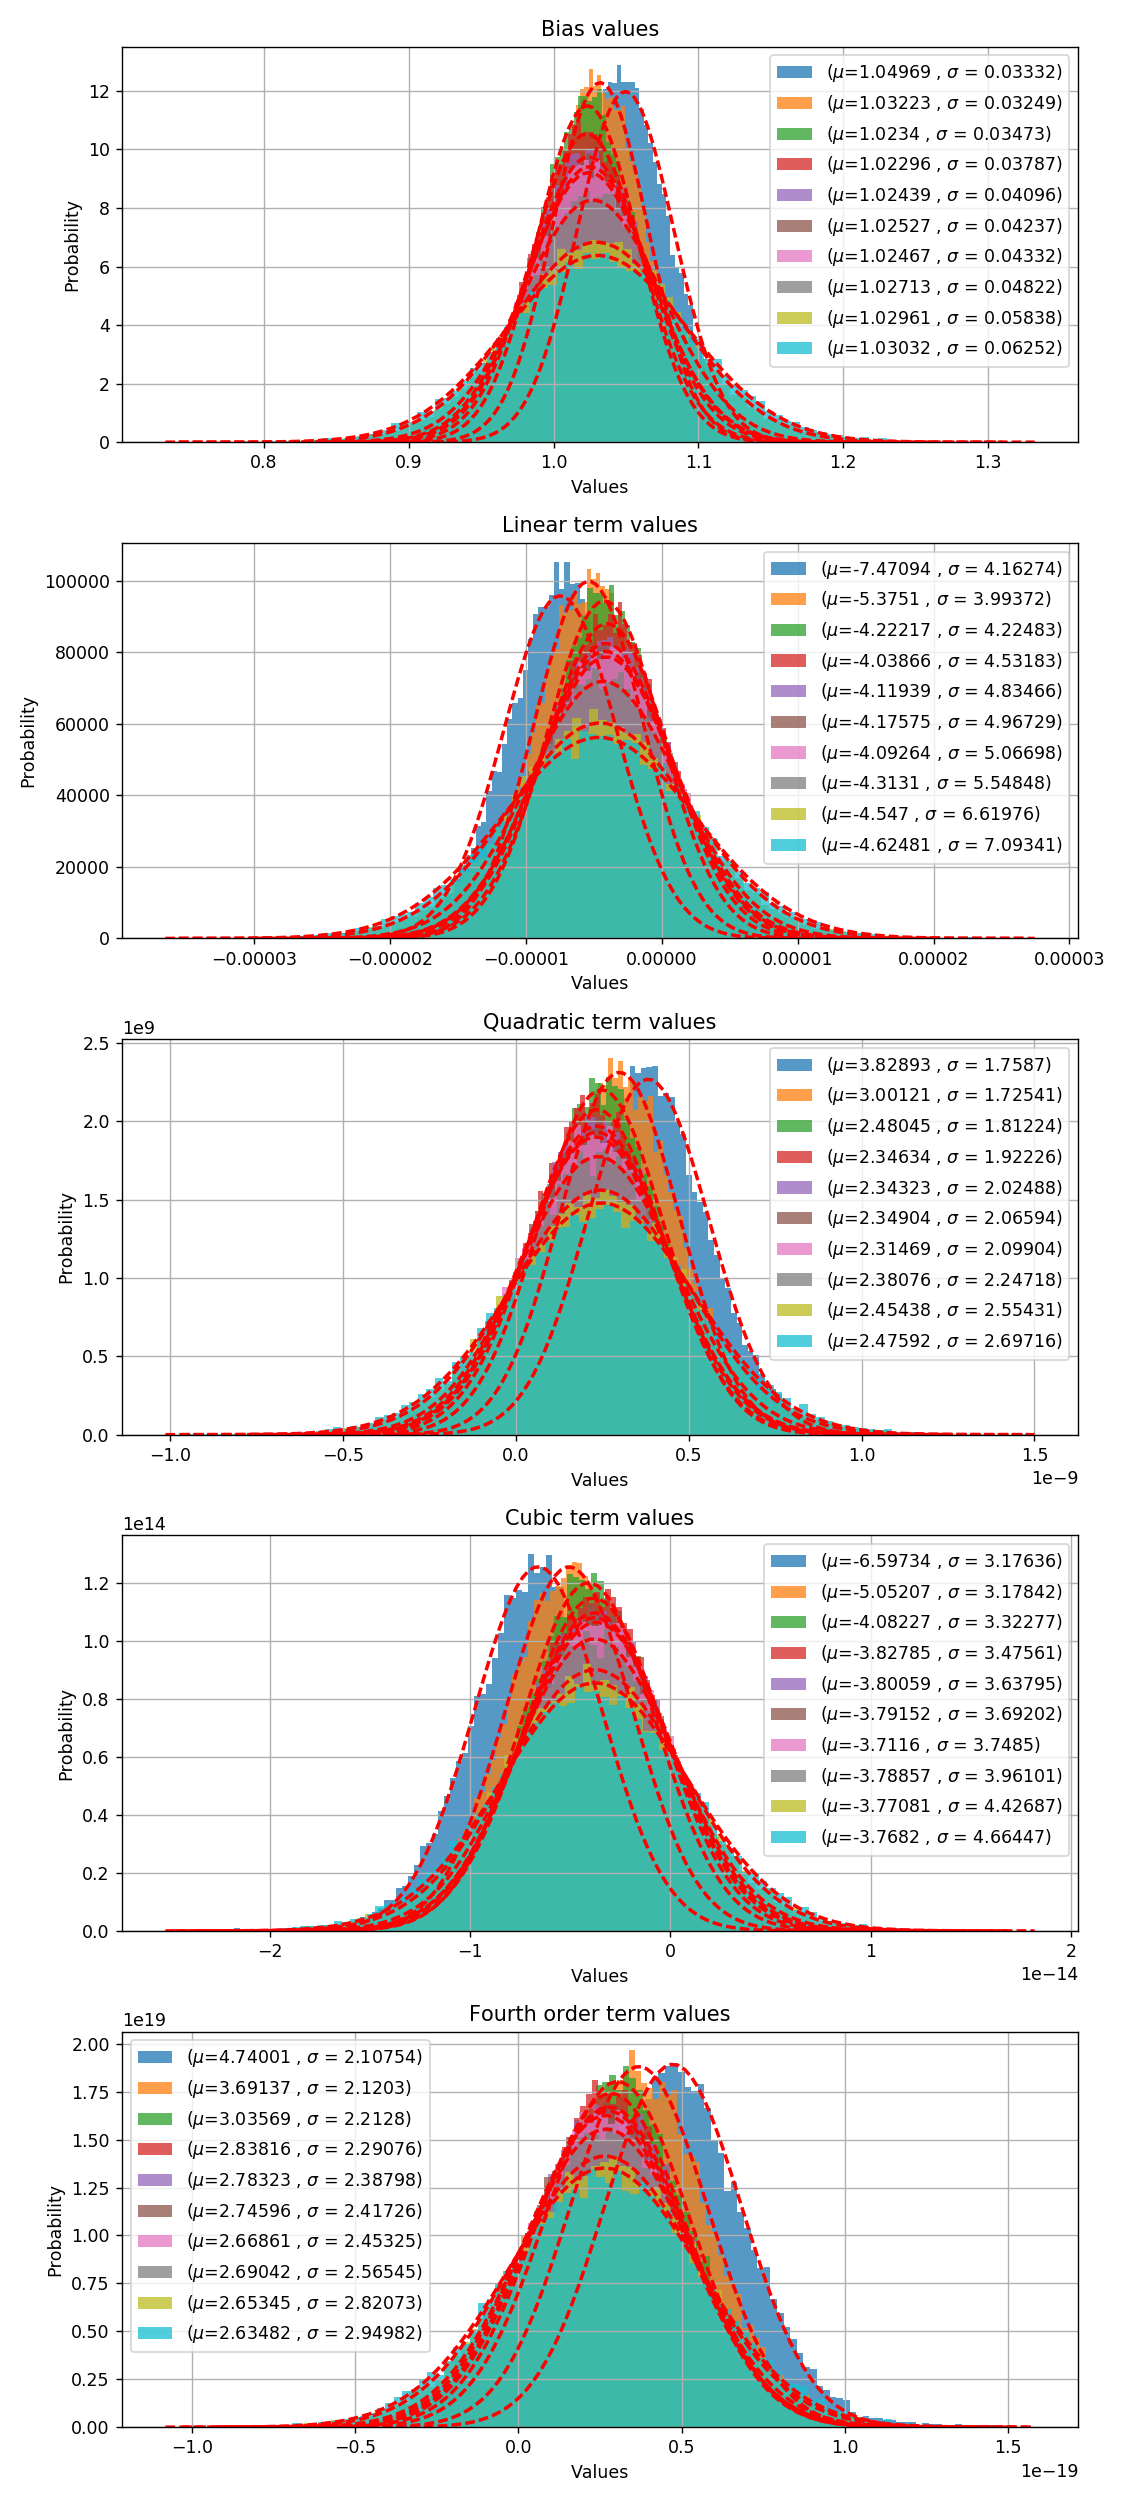

In [47]:
plt.close('all')

parameters =  {'0':'Bias','1':'Linear term','2':'Quadratic term','3':'Cubic term','4':'Fourth order term'}
parameter_range = {'0':[0.8,1.2],'1':[-30*1e-6,30*1e-6],'2':[-5*1e-10,10*1e-10],'3':[-15*1e-15,15*1e-15],'4':[-7*1e-20,10*1e-20]}
scale_factor = {'0':1,'1':10**6,'2':10**10,'3':10**15,'4':10**20}

band = '3C'
wavl_dic[band] = []
mean_values_dic[band],sigma_values_dic[band] = {},{}

out_parameters = out_parameters_dic[band]
d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)

nrows = 100

for i in range(1024/nrows):
    sel = (d2cMaps['sliceMap'][i*nrows:(i+1)*nrows,:] > 100*int(band[0])) & (d2cMaps['sliceMap'][i*nrows:(i+1)*nrows,:] < 100*(int(band[0])+1) )
    wavl_dic[band].append(np.mean(d2cMaps['lambdaMap'][i*nrows:(i+1)*nrows,:][sel]))

fig,axs = plt.subplots(5,1,figsize=(9,20))
for parameter in range(5):
    mean_values_dic[band][str(parameter)],sigma_values_dic[band][str(parameter)] = [],[]
    for i in range(1024/nrows):
        sel = (d2cMaps['sliceMap'][i*nrows:(i+1)*nrows,:] > 100*int(band[0])) & (d2cMaps['sliceMap'][i*nrows:(i+1)*nrows,:] < 100*(int(band[0])+1) )
        (mu, sigma) = norm.fit(out_parameters[parameter,i*nrows:(i+1)*nrows,:][sel][(out_parameters[parameter,i*nrows:(i+1)*nrows,:][sel] > parameter_range[str(parameter)][0]) & (out_parameters[parameter,i*nrows:(i+1)*nrows,:][sel] < parameter_range[str(parameter)][1])])
        n, bins, patches = axs[parameter].hist(out_parameters[parameter,i*nrows:(i+1)*nrows,:][sel][(out_parameters[parameter,i*nrows:(i+1)*nrows,:][sel] > mu-5*sigma) & (out_parameters[parameter,i*nrows:(i+1)*nrows,:][sel] < mu+5*sigma)], 100, normed=1, alpha=0.75,label=r'($\mu$={} , $\sigma$ = {})'.format(round(mu*scale_factor[str(parameter)],5), round(sigma*scale_factor[str(parameter)],5) ))
        
        mean_values_dic[band][str(parameter)].append(mu)
        sigma_values_dic[band][str(parameter)].append(sigma)
        
        y = mlab.normpdf(bins, mu, sigma)
        axs[parameter].plot(bins, y, 'r--', linewidth=2)
        
    axs[parameter].set_xlabel('Values')
    axs[parameter].set_ylabel('Probability')
    axs[parameter].set_title('{} values'.format(parameters[str(parameter)]))
    axs[parameter].legend()
    axs[parameter].grid(True)
plt.tight_layout()

<IPython.core.display.Javascript object>


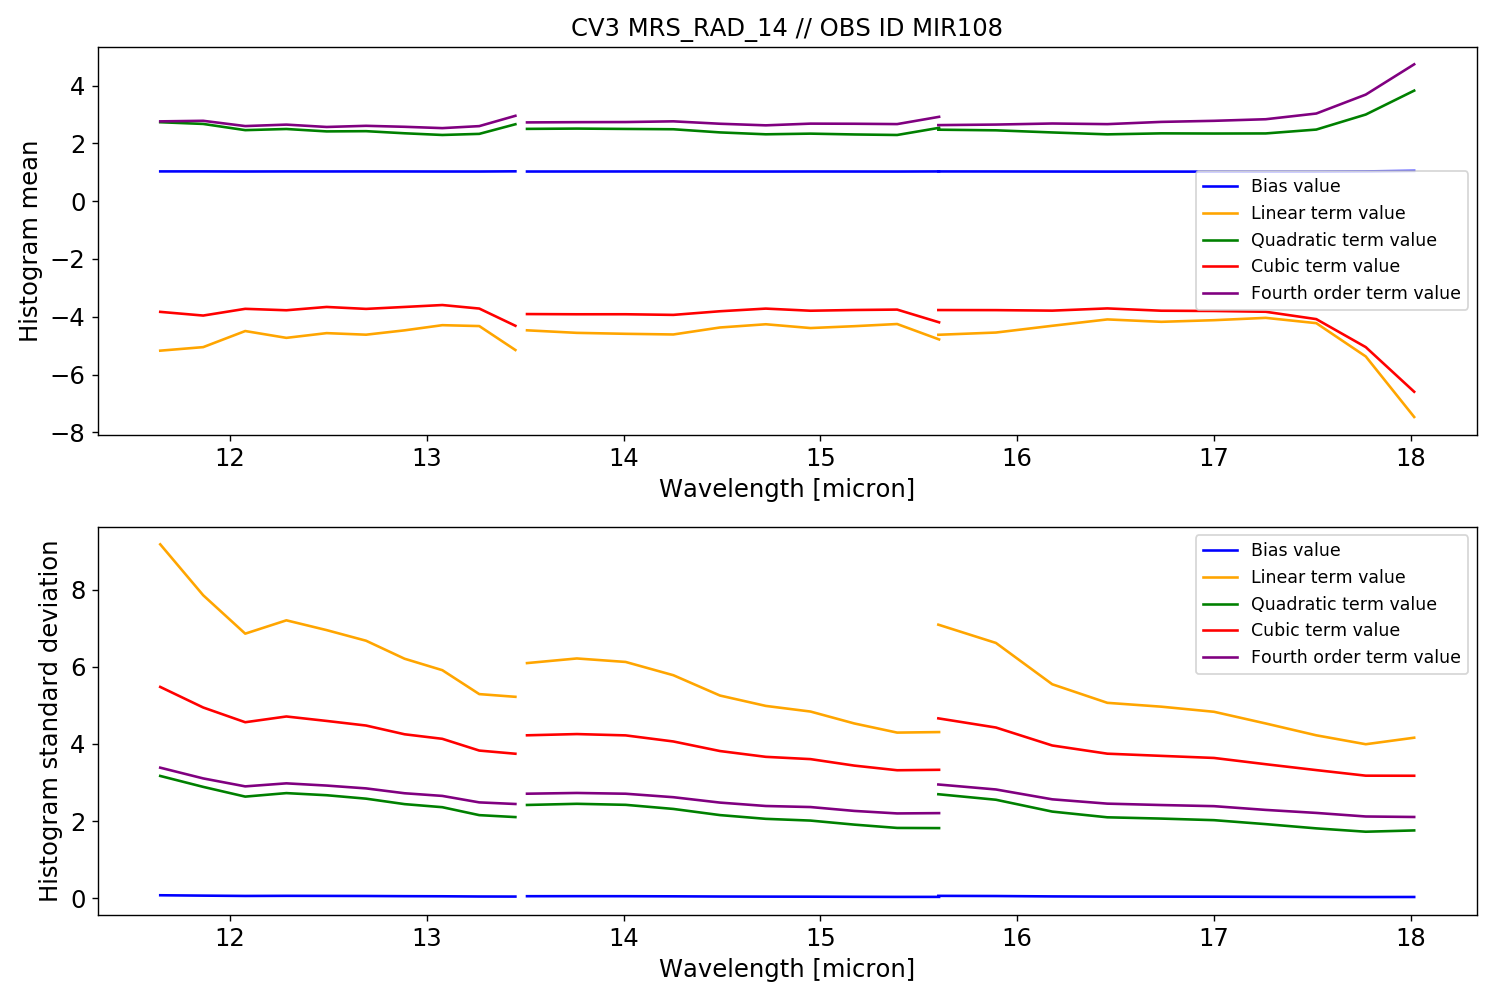

In [48]:
colors = ['b','orange','green','r','purple']
bands = ['3A','3B','3C']

fig,axs = plt.subplots(2,1,figsize=(12,8))
for band in bands:
    for parameter in range(5):
        if band == bands[0]:
            axs[0].plot(wavl_dic[band],np.array(mean_values_dic[band][str(parameter)])*scale_factor[str(parameter)],colors[parameter],label='{} value'.format(parameters[str(parameter)]))
            axs[1].plot(wavl_dic[band],np.array(sigma_values_dic[band][str(parameter)])*scale_factor[str(parameter)],colors[parameter],label='{} value'.format(parameters[str(parameter)]))
        else:
            axs[0].plot(wavl_dic[band],np.array(mean_values_dic[band][str(parameter)])*scale_factor[str(parameter)],colors[parameter])
            axs[1].plot(wavl_dic[band],np.array(sigma_values_dic[band][str(parameter)])*scale_factor[str(parameter)],colors[parameter])
axs[0].set_xlabel('Wavelength [micron]',fontsize=14)
axs[0].set_ylabel('Histogram mean',fontsize=14)
axs[1].set_xlabel('Wavelength [micron]',fontsize=14)
axs[1].set_ylabel('Histogram standard deviation',fontsize=14)
for plot in range(2):
    axs[plot].tick_params(axis='both',labelsize=14)
    axs[plot].legend()
axs[0].set_title('CV3 MRS_RAD_14 // OBS ID MIR108'.format(band),fontsize=14)
plt.tight_layout()

<IPython.core.display.Javascript object>


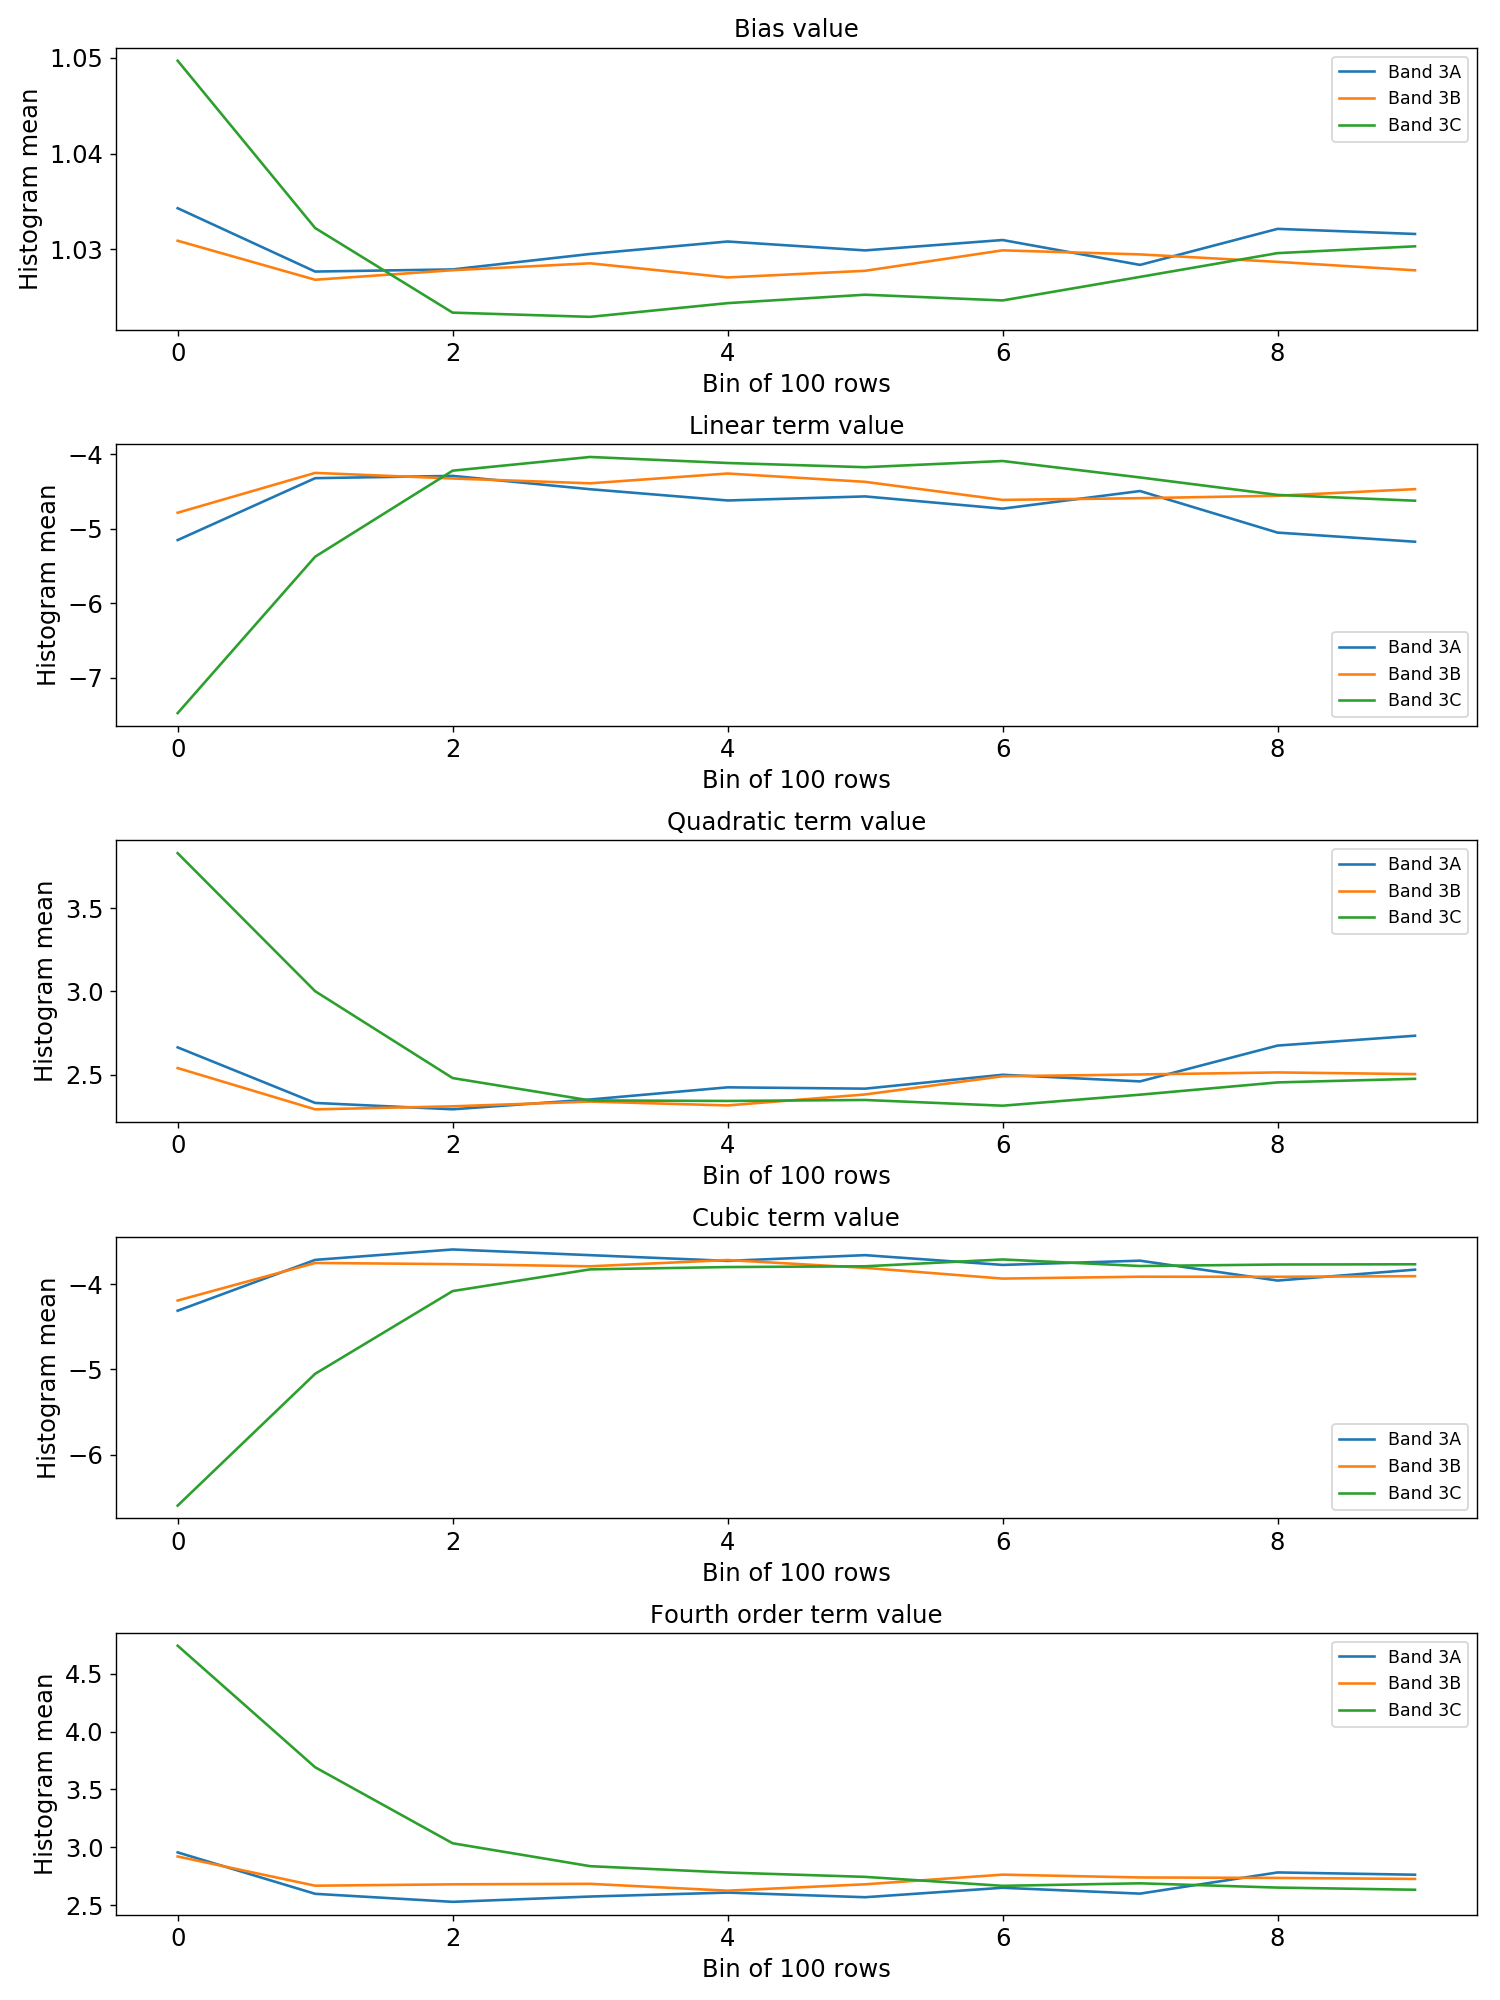

In [67]:
plt.close('all')
colors = ['b','orange','green','r','purple']
bands = ['3A','3B','3C']

fig,axs = plt.subplots(5,1,figsize=(12,16))
for parameter in range(5):
    for band in bands:
        axs[parameter].plot(np.array(mean_values_dic[band][str(parameter)])*scale_factor[str(parameter)],label='Band {}'.format(band))
    axs[parameter].set_xlabel('Bin of {} rows'.format(nrows),fontsize=14)
    axs[parameter].set_ylabel('Histogram mean',fontsize=14)
    axs[parameter].tick_params(axis='both',labelsize=14)
    axs[parameter].legend()
    axs[parameter].set_title('{} value'.format(parameters[str(parameter)]),fontsize=14)
plt.tight_layout()